<a href="https://colab.research.google.com/github/Tanulshn/Python-and-DS-work/blob/main/ARIMA_TSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basic Package
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Warnings 
import warnings
warnings.simplefilter(action='ignore')


### Data Preprocessing

In [2]:
# Read the data
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Time Series Analysis/Banks/HDFC Bank/2 yr TSA.csv')
raw_data.head(20)

,Date,Value,Price
0,6/1/2019,No Data FOund,No Data FOund
1,6/2/2019,No Data FOund,No Data FOund
2,6/3/2019,31.80974372,1228.55
3,6/4/2019,31.74760267,1226.15
4,6/5/2019,No Data FOund,No Data FOund
5,6/6/2019,31.37281447,1211.675
6,6/7/2019,31.68740353,1223.825
7,6/8/2019,No Data FOund,No Data FOund
8,6/9/2019,No Data FOund,No Data FOund
9,6/10/2019,31.59095544,1220.1


In [3]:
df=raw_data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    731 non-null    object
 1   Value   731 non-null    object
 2   Price   731 non-null    object
dtypes: object(3)
memory usage: 17.3+ KB


In [4]:
# Change the dtype
for i in (['Value','Price']):
  df[i]=pd.to_numeric(raw_data[i], errors= 'coerce').round(2)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    731 non-null    object 
 1   Value   494 non-null    float64
 2   Price   494 non-null    float64
dtypes: float64(2), object(1)
memory usage: 17.3+ KB


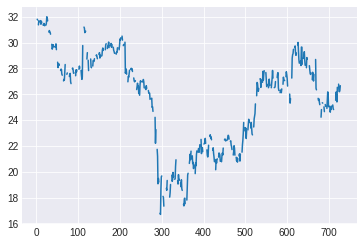

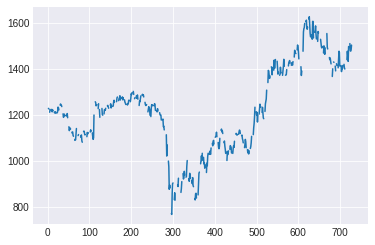

In [5]:
df['Value'].plot()
plt.show()
df['Price'].plot()

In [6]:
df.corr()

,Value,Price
Value,1.000000,0.673561
Price,0.673561,1.000000


#### Date-time formatting

In [7]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst = False)
df.set_index('Date', inplace=True)
df.isnull().sum()

Value    237
Price    237
dtype: int64

In [8]:
# Business days time series
data = df.resample('b').last()
data.isnull().sum()

Value    31
Price    31
dtype: int64

In [9]:
data.fillna(method='bfill', inplace=True)

In [10]:
data.isnull().sum()

Value    0
Price    0
dtype: int64

In [11]:
data.shape

(522, 2)

## Test for Stationarity

In [12]:
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller

In [13]:
# Define a function for Stationarity check

def adfuller_test(series):
  """ Takes the series and tests whether the series is stationary or not 
  by using ADFULLER test.
  """
  result = adfuller(series)
  labels = ['ADF Test stat', 'p-value', '# Lags', '# observations']
  for value, label in zip(result,labels):
    print(label, ': ', str(value))

  if result[1]<=0.05:
    print('Outcome: Strong evidence against the null hypothesis; reject H0; data has no unit root; DATA IS STATIONARY.')
  else:
    print('Outcome: Weak evidence against H0; accept H0, DATA IS NOT STATIONARY') 


In [14]:
adfuller_test(data['Price'])

ADF Test stat :  -0.9667821344274781
p-value :  0.7651861831579707
# Lags :  4
# observations :  517
Outcome: Weak evidence against H0; accept H0, DATA IS NOT STATIONARY


Conclusion: The Data is not stationary
We need to induce stationarity to be able to perform forecast through ARIMA

### Induce Stationarity

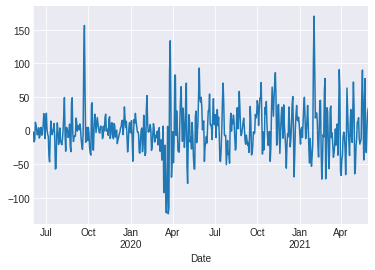

In [15]:
# First degree differencing
stationary_series = data['Price'].diff(2).dropna()
stationary_series.plot()

In [16]:
# Check for stationarity
adfuller_test(stationary_series)

ADF Test stat :  -5.332410724983448
p-value :  4.689713708385117e-06
# Lags :  14
# observations :  505
Outcome: Strong evidence against the null hypothesis; reject H0; data has no unit root; DATA IS STATIONARY.


Now that the snew series is stationary, we can plot ACF and PACF to determine the p and q variables for ARIMA

## Autocorrelation check

In [17]:
# Create train set
train_size = int(len(data)*0.7)
train_size

365

In [18]:
import statsmodels.graphics.tsaplots as sgt

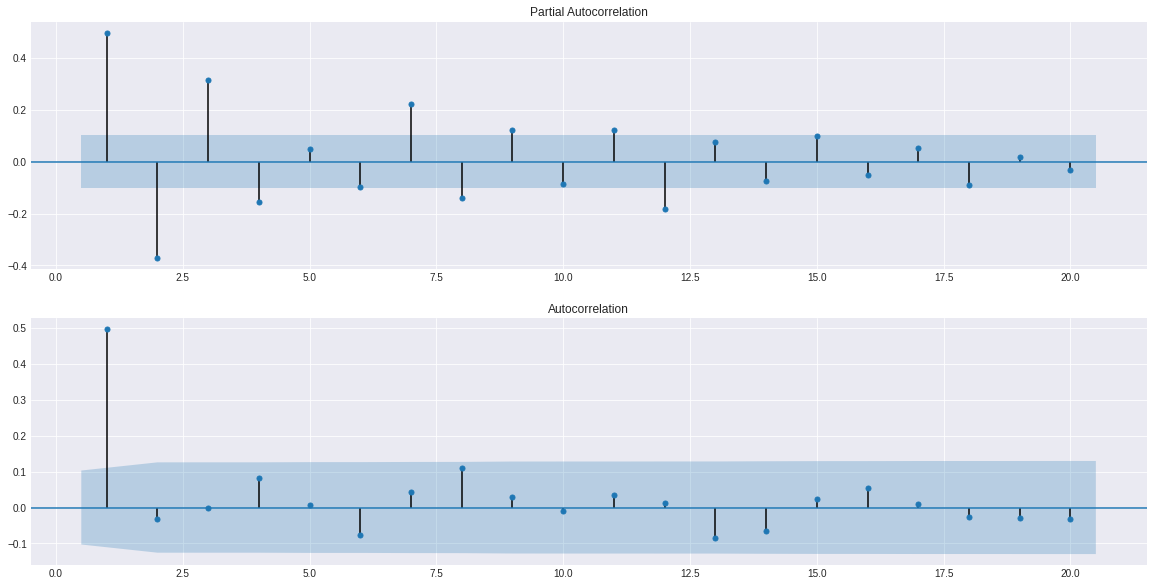

In [19]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = sgt.plot_pacf(data['Price'][:train_size].diff(2).dropna(), lags=20, ax=ax1,zero= False)

ax2 = fig.add_subplot(212)
fig = sgt.plot_acf(data['Price'][:train_size].diff(2).dropna(), lags=20, ax=ax2, zero= False)



Conclusion:

Value of p: No of lags for AR (PACF Plot): 6

Value of q: No of lags for MA (ACF Plot):  6


## ARIMA model

In [20]:
# Import package
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [21]:
# Define a function to call:

def predict_ARIMA(train_data):
  """ The fun will fit ARIMA on the train data and forecast
  """
  model = ARIMA(train_data, order=(2,2,1))
  
  # Fit the model
  try:
    model_fit = model.fit(disp=0)
    #Forecast
    forecast = model_fit.forecast() 
    return forecast[0][0]
  except:
    pass

In [22]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)

# Find the params
model = ARIMA(data['Price'][:train_size], order=(2, 2, 1))
model_fit_0 = model.fit()
print(model_fit_0.params.round(2))

const             0.01
ar.L1.D2.Price    0.02
ar.L2.D2.Price   -0.03
ma.L1.D2.Price   -1.00
dtype: float64


In [23]:
data['Pred'] = data['Price'].rolling(train_size).apply(predict_ARIMA).round(2)
data['Pred'] = data['Pred'].shift(1)

In [24]:
data.tail()

,Value,Price,Pred
Date,,,
2021-05-25,26.23,1478.95,1511.16
2021-05-26,26.19,1477.05,1480.47
2021-05-27,26.29,1482.65,1481.62
2021-05-28,26.66,1503.45,1486.04
2021-05-31,26.88,1515.85,1507.07


### ARIMA model evaluation

In [25]:
def model_performance(actual, predicted):
  """ This function will print the MAE, MSE, RMSE and Mean Absolute percentage error (MAPE)
  This will also plot PACF an residual plot"""

  #Mean Absolute error
  mae = mean_absolute_error(actual, predicted).round(2)
  print('The Mean Absolute Error is: ', mae)
  
  #Mean Squared Error 
  mse = mean_squared_error(actual, predicted).round(2)
  print('The Mean Squared Error is: ', mse)

  # Root Mean Squared Error
  rmse = np.sqrt(mse).round(2)
  print('The RMSE is: ', rmse )

  # Mean Absolute percentage error
  mape = 100*((actual-predicted)/actual).abs().mean()
  print('The Mean Absolute Percentage Error is: ', mape)

  # Residuals
  residuals = actual- predicted
  labels = actual.index
  #fig,(ax1,ax2) = plt.subplot(2,1, figsize=(12,11))

  # Plot Graph
  plt.figure(figsize=(15,10))
  
  plt.subplot(2,1,1)
  plt.plot(actual, color = 'red')
  plt.plot(predicted, color = 'blue' )
  plt.ylabel('Price')
  plt.title('Predicted v/s Actual')

  # Plot PACF
  plt.subplot(2,1,2)
  sgt.plot_acf(residuals, color= 'green')
  plt.xlabel('Lags')
  plt.ylabel('Autocorrelation')
  plt.title('Autocorrelation of Residuals')

  plt.tight_layout()
  plt.show()

The Mean Absolute Error is:  20.39
The Mean Squared Error is:  718.3
The RMSE is:  26.8
The Mean Absolute Percentage Error is:  1.4124774989246776


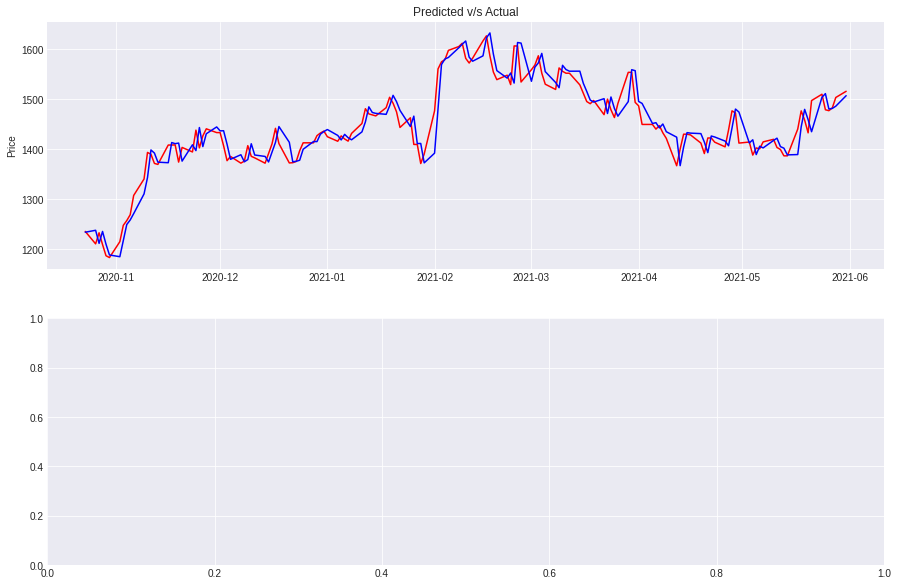

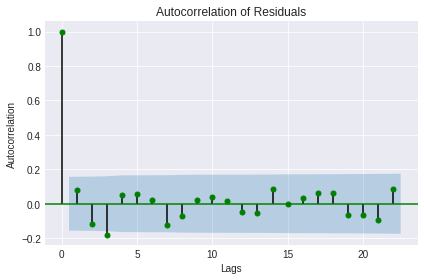

In [26]:
model_performance(data['Price'].iloc[train_size:],data['Pred'].iloc[train_size:])

### Trade Strategy- Long Short

What are we trying to do in the strategy:
- Create Signal - When the predicted price is higher than previous day actual price, create a signal +1, or -1 if not.
- Signal implies the direction for the returns.
- *Strategy* returns- Creating a hypothetical return (Pred return), in case the position was held throughout the tennure. 

In [36]:
data['Return'] = data['Price'].pct_change()
data['Position'] = np.where(data['Pred'].shift(1) < data['Pred'], 1,-1)

data['Strategy_return'] = data['Return']* data['Position']

data.tail(15)

,Value,Price,Pred,Return,Position,Strategy_return
Date,,,,,,
2021-05-11,24.88,1403.55,1422.14,-0.011480,1,-0.011480
2021-05-12,24.81,1399.50,1405.29,-0.002886,-1,0.002886
2021-05-13,24.58,1386.85,1402.13,-0.009039,-1,0.009039
2021-05-14,24.58,1386.85,1388.76,0.000000,-1,-0.000000
2021-05-17,25.53,1440.25,1389.41,0.038505,1,0.038505
2021-05-18,26.17,1476.70,1444.75,0.025308,1,0.025308
2021-05-19,25.85,1458.20,1479.70,-0.012528,1,-0.012528
2021-05-20,25.40,1432.80,1459.21,-0.017419,-1,0.017419
2021-05-21,26.54,1497.30,1435.06,0.045017,-1,-0.045017


In [37]:
# Define a function to analyse the returns

def analyse_strategy(return_series):
  """ Takes the Returns column as input and performs few calculations
  Sharpe ratio- Return to risk ratio
  Cumulative return - Month over month return calculated
  Drawdown calculation
  Print statistics
  """
  sharpe_ratio = return_series.mean()/return_series.std()*np.sqrt(252)

  #Cumulative Returns
  cum_return = (return_series+1).cumprod()
  

  print('The Sharpe Ratio is %.2f' % sharpe_ratio)
  print('The cumulative return is %.2f' % (((cum_return[-1])-1)*100) + "%") 
  print('The std dev is: ', return_series.std())
  print( ' The number of days for retrn assessment: ', int(len(return_series)))
  # Plots
  labels = return_series.index
  plt.figure(figsize=(15,10))

  #Plot strategy return
  plt.plot(cum_return, color = 'b')
  plt.title('Cumulative returns', fontsize=14)
  plt.ylabel('Cumulative Return')
  plt.xlabel('Date')

The Sharpe Ratio is 1.01
The cumulative return is 17.04%
The std dev is:  0.01851381215259276
 The number of days for retrn assessment:  157


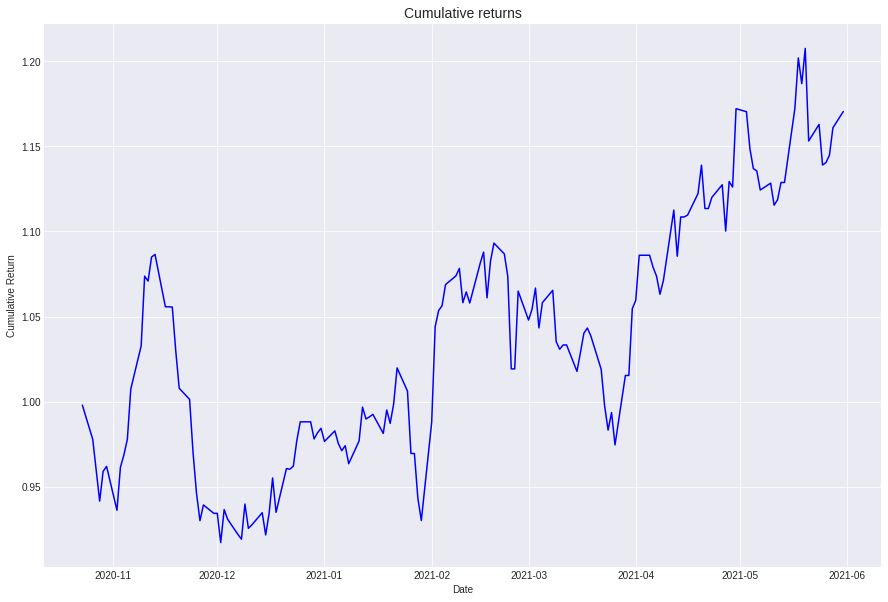

In [38]:
analyse_strategy(data['Strategy_return'].iloc[train_size:])

### Trade Strategy- Long Only

What are we trying to do in the strategy:
- Create Signal - When the predicted price is higher than previous day actual price, create a signal +1, or 0.
- Signal implies the direction for the returns.
- *Strategy* returns- Creating a hypothetical return (Pred return), in case the position was held throughout the tennure. 

In [39]:
data['Return'] = data['Price'].pct_change()
data['Position'] = np.where(data['Pred'].shift(1) < data['Pred'], 1,0)

data['Strategy_return'] = data['Return']* data['Position']

data.tail(15)

,Value,Price,Pred,Return,Position,Strategy_return
Date,,,,,,
2021-05-11,24.88,1403.55,1422.14,-0.011480,1,-0.011480
2021-05-12,24.81,1399.50,1405.29,-0.002886,0,-0.000000
2021-05-13,24.58,1386.85,1402.13,-0.009039,0,-0.000000
2021-05-14,24.58,1386.85,1388.76,0.000000,0,0.000000
2021-05-17,25.53,1440.25,1389.41,0.038505,1,0.038505
2021-05-18,26.17,1476.70,1444.75,0.025308,1,0.025308
2021-05-19,25.85,1458.20,1479.70,-0.012528,1,-0.012528
2021-05-20,25.40,1432.80,1459.21,-0.017419,0,-0.000000
2021-05-21,26.54,1497.30,1435.06,0.045017,0,0.000000


The Sharpe Ratio is 1.56
The cumulative return is 21.44%
The std dev is:  0.013541881767528699
 The number of days for retrn assessment:  157


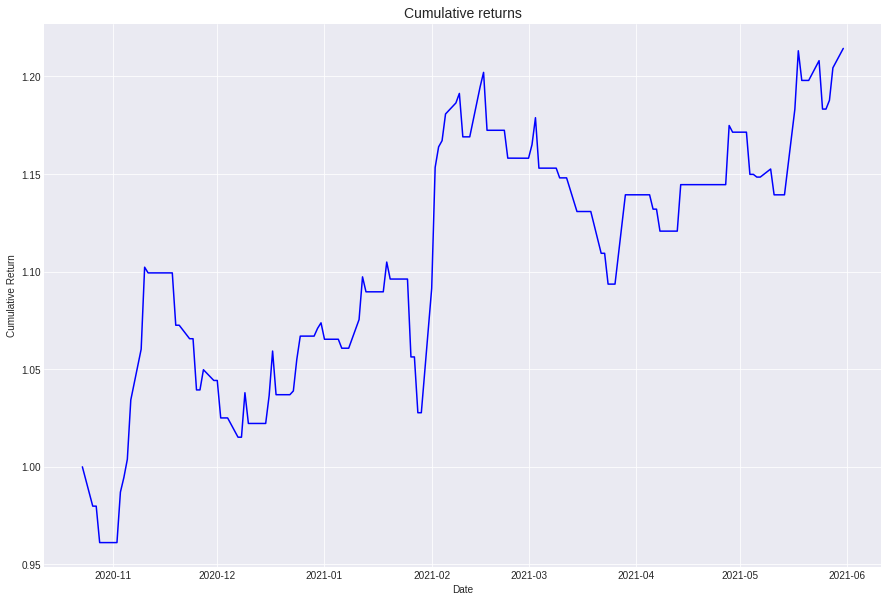

In [40]:
analyse_strategy(data['Strategy_return'].iloc[train_size:])